In [1]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib as mpl
import copy
import dataclasses

import os, sys
import pickle as pkl
from scipy import interpolate
import scipy as sp
import pprint

from fusiondls.geometry import *
from fusiondls.unpackConfigurationsMK import unpackConfigurationMK

from fusiondls import MagneticGeometry, SimulationInputs, run_dls, file_read, file_write
from fusiondls.analytic_cooling_curves import LfuncKallenbach

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))

from DLS.postprocess import *
from code_comparison.solps_pp import *
from sdtools.general.plotstyle import change_colors
change_colors("default")

%matplotlib inline
%load_ext autoreload
%autoreload 2


# Read SOLPS case

In [2]:
balance_paths = {
    "100MW_inner_arpuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed\step0_A5e21D1e24spr",
    "100MW_innerar_midplanepuff" : r"C:\Users\Mike\OneDrive\Project\DLS\from ryoko\2024-11-05 - CDN V10 runs\V10_100MW_inner_ar_seed_impomp_puff\step2_Xomp20_A8e21D0p4e24sp50r",
}

store_slc = {}

for case in balance_paths:
    print(case)
    if "balance.nc" in os.listdir(balance_paths[case]):
        store_slc[case] = SOLPScase(balance_paths[case])
        store_slc[case].get_species()
        store_slc[case].get_impurity_stats("Ar", all_states = True)
    else:
        print(f"Skipping {case} as no balance.nc file found")
        
case = "100MW_innerar_midplanepuff"
sepadd_select = dict(outer_lower = 2, inner_lower = 1)

100MW_inner_arpuff
Saving all states
Added total radiation, density and fraction for Ar
100MW_innerar_midplanepuff
Saving all states
Added total radiation, density and fraction for Ar


# Common formatting stuff

In [3]:
labels = {'100MW_inner_arpuff' : "PFR puff", '100MW_innerar_midplanepuff' : "Midplane puff"}

# Prepare DLS geometry from SOLPS
- eqb is the usual high res interpolated version
- eqb_alt uses SOLPS data explicitly for an identical comparison

In [4]:
def translate_side(x):
    return x.split("_")[0][0] + x.split("_")[1][0]

translate_side("inner_lower")

'il'

In [5]:
eqb = dict()       # Geometry calculated using DLS built-in routines
eqb_alt = dict()   # Geometry calculated with my SOLPS post-processing routines

for case in balance_paths:
    print(case)
    eqb[case] = dict()
    eqb_alt[case] = dict()
    for region in ["outer_lower", "inner_lower", "outer_upper", "inner_upper"]:
        eqb[case][region] = dict()
        eqb_alt[case][region] = dict()
        for i in range(10):
            eqb[case][region][i] = unpackConfigurationMK(
                File = os.path.join(balance_paths[case], "balance.nc"), Type = region.split("_")[0][0] + region.split("_")[1][0], sepadd=i, 
                resolution = 500, diagnostic_plot = False)
            
            
            df = store_slc[case].get_1d_poloidal_data(["R", "Z", "Btot", "Bpol"], 
                                                      region = region, sepadd = i,
                                                      target_first = True).reset_index(drop = True)
            
            params = {}
            
            for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
                params[key] = np.array(df[key].values)
                
            params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            geom = MagneticGeometry(
                Bpol = params["Bpol"], 
                Btot = params["Btot"],
                R = params["R"],
                Z = params["Z"],
                Spar = params["Spar"],
                Spol = params["Spol"],
                Xpoint = params["Xpoint"])

            
            eqb_alt[case][region][i] = geom
            
            # eqb_alt[case][region][i] = Profile(params["R"], params["Z"], df[df["Xpoint"]==1].index[0], params["Btot"], params["Bpol"], params["Spar"], params["Spol"], name = "outer_lower_sepadd1")
    

100MW_inner_arpuff
100MW_innerar_midplanepuff


# Prepare cooling curves

In [6]:
curves = {}
T = np.linspace(0, 1000, 1000)

## radas

In [7]:
rd_Ar = xr.open_dataset(r"C:\Users\Mike\OneDrive\Project\DLS\radas-curves\radas_dir\output\argon.nc")

curves["neTau"] = {}

for netau in rd_Ar.coords["dim_ne_tau"].values:
    rate = rd_Ar["equilibrium_Lz"].sel(dim_ne_tau = netau, dim_electron_density=1e20, method="nearest")
    netau_name = netau
    curves["neTau"][netau_name*1000] = sp.interpolate.interp1d(
        rd_Ar.coords["dim_electron_temp"].values, rate.values, kind = "cubic",
        fill_value = (rate.values[0], rate.values[-1]), bounds_error = False
        )


## SOLPS

In [ ]:
curves_choice = 

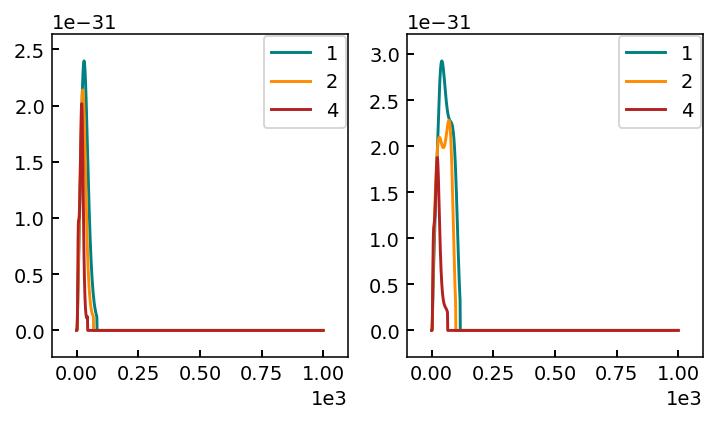

In [8]:
curves["extracted_outer"] = {}
curves["extracted_inner"] = {}

for i in range(8):
    curves["extracted_outer"][i] = store_slc[case].extract_cooling_curve("Ar", "outer_lower", sepadd = i, order = 10)
    curves["extracted_inner"][i] = store_slc[case].extract_cooling_curve("Ar", "inner_lower", sepadd = i, order = 8)
    
    
fig, axes = plt.subplots(1,2, figsize = (6,3))

for i in [1,2,4]:

    axes[0].plot(T, [curves["extracted_inner"][i](temp) for temp in T], label = i)
    axes[1].plot(T, [curves["extracted_outer"][i](temp) for temp in T], label = i)
    
for ax in axes:
    ax.legend()


## Custom

In [120]:
def LfuncArParametricTriShoulder(T, x1 = 0, x2 = 60, height = 0.5, scale = 1):
    """
    Analytical approximation of the Ar cooling curve
    Tmax is the temperature at which the radiation goes to zero on the hot end
    
    """
    
    # Maximum from actual Ar curve
    max = 1.7210363586464083e-31
    
    x0 = 0
    y0 = 0
    # x1 = max_pos
    y1 = max
    # x2 = 
    y2 = max * height
    

    if T < x1:
        Lz = (y0 * (x1 - T) + y1 * (T - x0)) / (x1 - x0)
    elif T >= x1 and T < x2:
        Lz = (y1 * (x2 - T) + y2 * (T - x1)) / (x2 - x1)
    else:
        Lz = y2

    
    return Lz*scale

## Choose curves

In [ ]:
solps = [curves["extracted_outer"][sepadd_select["outer_lower"]](temp) for temp in T]
solps_integral = sp.integrate.trapz(solps, T)

thin = [LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0, scale = 12.679) for temp in T]
thin_integral = sp.integrate.trapz(thin, T)

print(solps_integral, thin_integral)
print(f"Ratio: {solps_integral/thin_integral:.3f}")

1.6365558811006316e-29 1.6365748594912672e-29
Ratio: 1.000


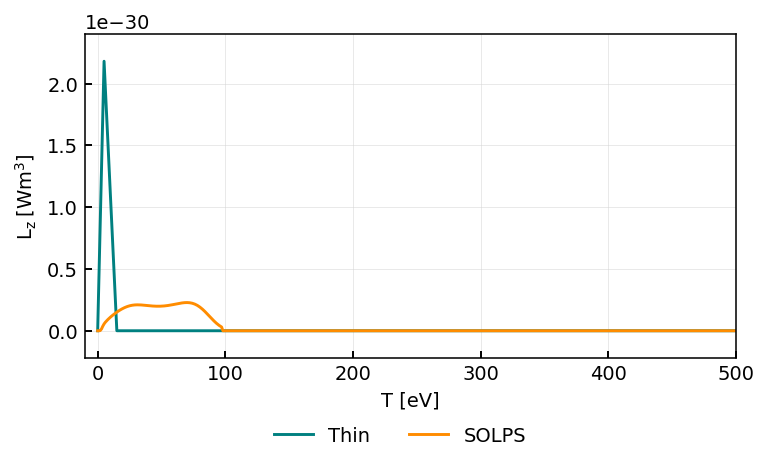

In [123]:
netau = 1e19

curves["set_outer"] = {
    "Thin" : lambda temp: LfuncArParametricTriShoulder(temp, x1 = 5, x2 = 15, height = 0, scale = 12.679),
    "SOLPS" : curves["extracted_outer"][sepadd_select["outer_lower"]],    
    
}
    
fig, ax = plt.subplots(figsize = (6,3))


for name, function in curves["set_outer"].items():
    Lz = [function(temp) for temp in T]
    # Lz = Lz/np.max(Lz)
    ax.plot(T, Lz, lw = 1.5, label = name)

ax.set_xlabel("T [eV]")
ax.set_ylabel(r"$L_z\ [W m^{3}]$")
fig.legend(loc = "upper center", bbox_to_anchor = (0.5,-0.03), ncol = 3, frameon = False)
ax.set_xlim(-10,500)
ax.grid()
# fig.savefig(r"C:\Users\mikek\OneDrive\Project\Papers\DLS IOP Proceedings\Figures\FrontEffects_curves_outer.pdf", format = "pdf")

## Compare curves

# Profile grid

## Make profile function

In [11]:
profiles = {}

## Make Super-X

In [46]:
type(base_profile)

fusiondls.geometry.MagneticGeometry

C:\Users\Mike\AppData\Local\Temp\ipykernel_28780\2480712981.py:32: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


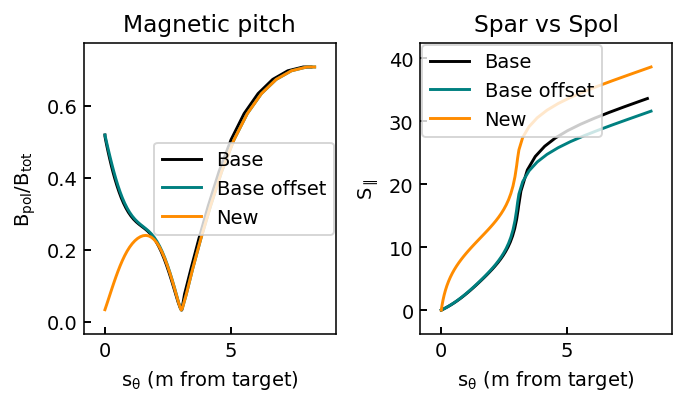

In [106]:
base_profile = eqb_alt["100MW_innerar_midplanepuff"]["outer_lower"][sepadd_select["outer_lower"]]


offsets = [
    {"pos": 1},
    {"pos": 0.75},
    {"pos": 0.50},
    {"pos": 0.25},
    {"pos": 0},
]
base_profile.Bpol = abs(base_profile.Bpol)
base = base_profile.copy()
base = base.offset_control_points(offsets).geometry

superx = base_profile.copy()
superx = superx.offset_control_points(offsets, Bpol_shift = {"width" : 1, "pos" : -1, "height" : 0.88}, constant_pitch = True).geometry

fig, axes = plt.subplots(1,2, figsize = (5,3), constrained_layout = True)

base_profile.plot(ax = axes[0], mode = "magnetic_pitch", parallel = False, label = "Base", color = "black")
base.plot(ax = axes[0], mode = "magnetic_pitch", parallel = False, label = "Base offset", color = "teal")
superx.plot(ax = axes[0], mode = "magnetic_pitch", parallel = False, label = "New", color = "darkorange")
axes[0].set_title("Magnetic pitch")

base_profile.plot(ax = axes[1], mode = "Spar_Spol", parallel = False, label = "Base", color = "black")
base.plot(ax = axes[1], mode = "Spar_Spol", parallel = False, label = "Base offset", color = "teal")
superx.plot(ax = axes[1], mode = "Spar_Spol", parallel = False, label = "New", color = "darkorange")
axes[1].set_title("Spar vs Spol")

for ax in axes:
    ax.legend()
fig.tight_layout()



## Make conventional

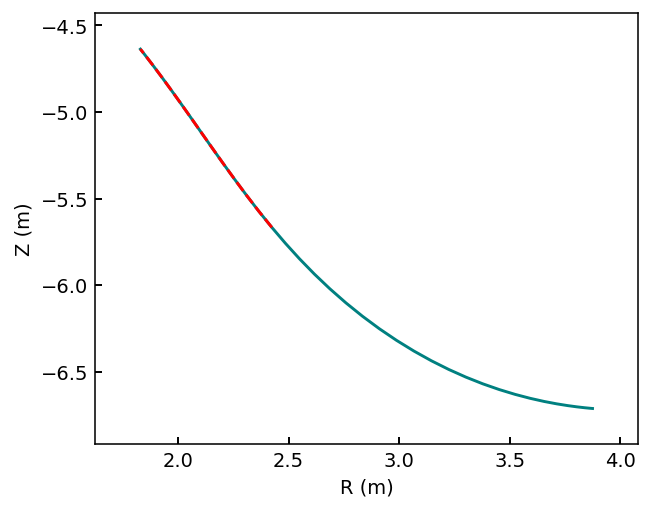

In [107]:
# Make dataframe from base profile
df = pd.DataFrame()
for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
    df[key] = base[key]
df["Xpoint"] = 0
df.loc[base["Xpoint"], "Xpoint"] = 1
    
# Trim it until R is about 2.5
df = df[df["Spar"] > 5.5].reset_index(drop = True)
df["Spar"] -= df["Spar"].min()
df["Spol"] -= df["Spol"].min()

params = {}

for key in ["R", "Z", "Btot", "Bpol", "Spol", "Spar"]:
    params[key] = np.array(df[key].values)
    
params["Xpoint"] = df[df["Xpoint"]==1].index[0]

            
conventional = MagneticGeometry(
                Bpol = params["Bpol"], 
                Btot = params["Btot"],
                R = params["R"],
                Z = params["Z"],
                Spar = params["Spar"],
                Spol = params["Spol"],
                Xpoint = params["Xpoint"])


fig, ax = plt.subplots()
base.plot(ax = ax, mode = "RZ")
conventional.plot(ax = ax, mode = "RZ", color = "red", ls = "--")


## Reorder profiles

In [108]:
profiles["outer"] = dict(
    conventional = conventional,
    extended_leg = base,
    superx = superx
)

# Run DLS

## Setup

In [109]:
def run_DLS(constants_input, profile, SparRange, slc, cvar, region, sepadd, hflux_corr=1):
    if "cooling_curve" not in constants_input.keys():
        print("WARNING: NO COOLING CURVE PROVIDED")

    df = slc.get_1d_poloidal_data(
        ["Ne"], sepadd=sepadd, region=region, target_first=True
    )
    nu = df["Ne"].iloc[-1]
    
    # This comes from the SOLPS comparison match for the specific SOL rings
    if "inner" in region:
        qpllu0 = 2.5e8 * 1.1
    else:
        qpllu0 = 3.0e8 * 1.06

    inputs = SimulationInputs(
        control_variable=cvar,
        SparRange=SparRange,
        qpllu0=qpllu0,
        nu0=nu,
        cz0=0.05,
        cooling_curve=constants_input["cooling_curve"],
        kappa0=slc.extract_kappa0(sepadd=sepadd, region=region),
        Ctol = 1e-4,
        Ttol = 1e-3,
        grid_refinement_ratio=5,
        grid_refinement_width=2,
        grid_resolution=10000,
    )
    
    try:
        out = run_dls(
            dataclasses.replace(inputs, **constants_input),
            profile,
        )

    except KeyboardInterrupt:
        print("Stopped")
        sys.exit(0)

    return out, compare_SOLPS_DLS(
        slc, out, cvar, impurity="Ar", region=region, sepadd=sepadd
    )

## Running

In [124]:
store = {}

### Outer

In [125]:
for study in ["outer"]:
    region = f"{study}_lower"
    store[study] = {}
    curve_choice = ["Thin", "SOLPS"]

    for curve in curve_choice:
        store[study][curve] = {}
        for profile_name in profiles[study]:
            input = dict(cooling_curve = curves[f"set_{study}"][curve])
            out, comp = run_DLS(
                input, profiles[study][profile_name], [0], store_slc[case],  "density", 
                region, sepadd_select[region], 
                hflux_corr = 1)  
            
            store[study][curve][profile_name] = out
        
    # comp.plot(["Cumrad", "qpar", "Te", "Ne", "Ne_cz"], normalise_radiation = True, radiation_per_area = False)

# Paper plot

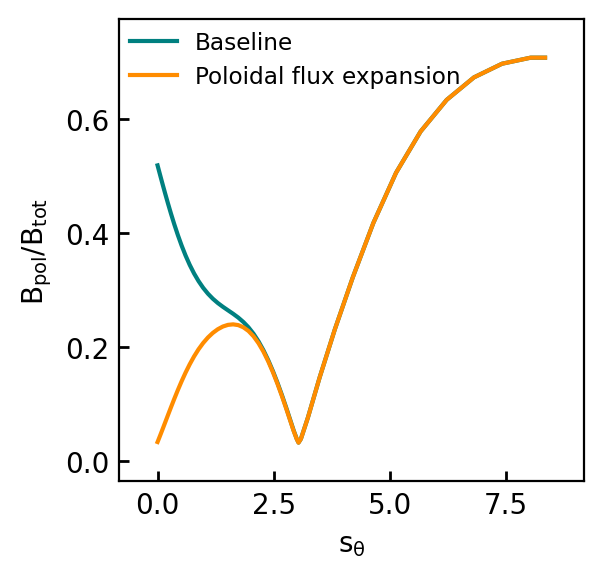

In [94]:
base_profile = eqb_alt["100MW_innerar_midplanepuff"]["outer_lower"][sepadd_select["outer_lower"]]
p1 = profiles["outer"]["base"]
p2 = profiles["outer"]["new"]


fig, ax = plt.subplots(1, figsize = (3,3), dpi = 200)

ax.plot(p1.Spol, p1.Bpol/p1.Btot, label = "Baseline")
ax.plot(p2.Spol, p2.Bpol/p2.Btot, label = "Poloidal flux expansion")

ax.set_xlabel(r"$s_{\theta}$")
ax.set_ylabel("$B_{pol}/B_{tot}$")
ax.legend(frameon = False, fontsize = "small")

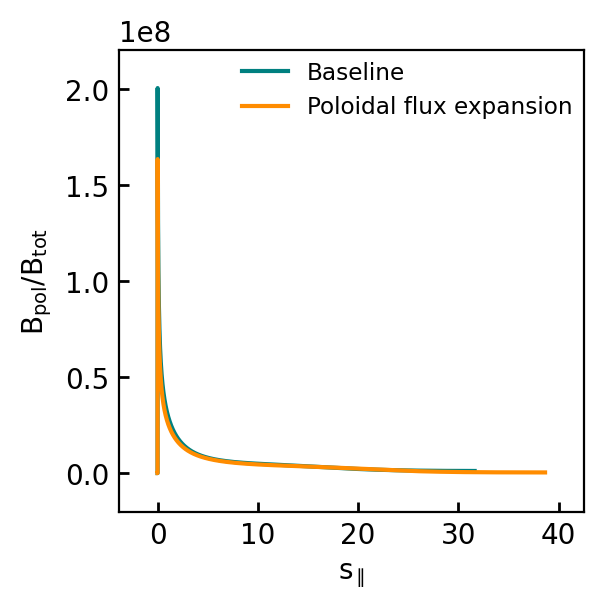

In [100]:
fig, ax = plt.subplots(1, figsize = (3,3), dpi = 200)

base = FrontLocation(store["outer"]["SOLPS"]["base"])
new = FrontLocation(store["outer"]["SOLPS"]["new"])

# ax.plot(base.data["Spar"], base.data["Qrad_cum_norm"], label = "Baseline")
# ax.plot(new.data["Spar"], new.data["Qrad_cum_norm"], label = "Poloidal flux expansion")

ax.plot(base.data["Spar"], base.data["Qrad"], label = "Baseline")
ax.plot(new.data["Spar"], new.data["Qrad"], label = "Poloidal flux expansion")

ax.set_xlabel(r"$s_{\parallel}$")
ax.set_ylabel("$B_{pol}/B_{tot}$")
ax.legend(frameon = False, fontsize = "small")

# Other postprocessing

In [34]:
sepadd_select.keys()

dict_keys(['outer_lower', 'inner_lower'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'inner radiation [W/m^3]')

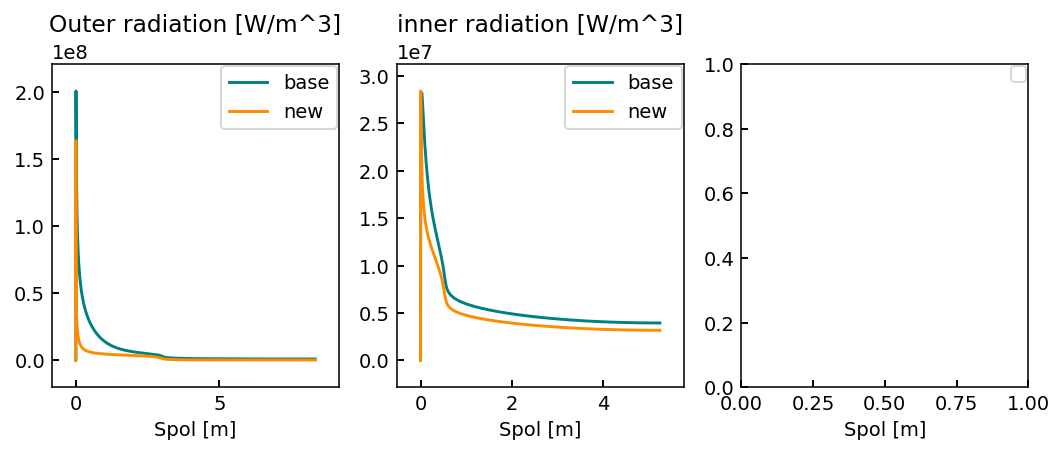

In [37]:
curve = "SOLPS"


fig, axes = plt.subplots(1,3, figsize =(3*3,3))
ax = axes[0]

study = "outer"
for profile_name in profiles[study]:
    dls = FrontLocation(store[study][curve][profile_name])
    axes[0].plot(dls.data["Spol"], dls.data["Qrad"], label = profile_name)
    
study = "inner"
for profile_name in profiles[study]:
    dls = FrontLocation(store[study][curve][profile_name])
    axes[1].plot(dls.data["Spol"], dls.data["Qrad"], label = profile_name)
    
for ax in axes:
    ax.legend()
    ax.set_xlabel("Spol [m]")

axes[0].set_title("Outer radiation [W/m^3]")
axes[1].set_title("inner radiation [W/m^3]")


In [116]:
store.keys()

dict_keys(['outer'])

## Profile comparison table

In [129]:
df = pd.DataFrame()

for name, geometry in profiles["outer"].items():
    df.loc["Lpar", name] = geometry.connection_length
    df.loc["fR", name] = geometry.total_flux_expansion
    df.loc["Bpol upstream", name] = geometry.Bpol[-1]
    df.loc["Bpol downstream", name] = geometry.Bpol[0]
    df.loc["fx", name] = geometry.Bpol[-1]*geometry.R[-1] / geometry.Bpol[0]*geometry.R[0]

df

,conventional,extended_leg,superx
Lpar,25.765341,31.619604,38.641304
fR,1.287205,1.812744,1.812744
Bpol upstream,1.471691,1.471691,1.471691
Bpol downstream,0.622588,0.940354,0.060354
fx,23.430972,24.783563,386.145106


## Results table

In [ ]:
def get_terms(base, new):

    dls1 = FrontLocation(base)
    dls2 = FrontLocation(new)
    
    df1 = pd.DataFrame([dls1.stats])
    df2 = pd.DataFrame([dls2.stats])
    df_ratio = (df2 / df1)

    terms = 1/df_ratio[["cvar", "Beff", "W_Tu", "curveclip", "upstream_rad"]]
    terms.rename(columns = {"cvar" : "Threshold"}, inplace = True)
    terms.insert(1, "Term product", terms.drop("Threshold", axis = 1).product(axis=1))
    
    return terms
    

In [139]:
len(profile.Btot)

50

In [137]:
len(profile.Spar)

50

In [145]:
from fusiondls.Analytic_DLS import CfInt

profile = profiles["outer"]["extended_leg"]

C = CfInt(
    spar = profile.Spar, 
    B_field = profile.Btot, 
    sx = profile["Spar"][profile.Xpoint], 
    L=profile.connection_length, 
    sh=0,
    Lfunc = curves["set_outer"]["SOLPS"],)

C

2033207399713.5452

In [146]:
df = pd.DataFrame()


for name, geometry in profiles["outer"].items():

    df.loc["Lpar", name] = geometry.connection_length
    df.loc["fR", name] = geometry.total_flux_expansion
    # df.loc["Bpol upstream", name] = geometry.Bpol[-1]
    # df.loc["Bpol downstream", name] = geometry.Bpol[0]
    df.loc["fx", name] = geometry.Bpol[-1]*geometry.R[-1] / geometry.Bpol[0]*geometry.R[0]
    
    df.loc["fR ratio", name] = geometry.total_flux_expansion / profiles["outer"]["conventional"].total_flux_expansion
    df.loc["Lc ratio", name] = geometry.connection_length / profiles["outer"]["conventional"].connection_length
    
    dls_thin = FrontLocation(store["outer"]["Thin"][name])
    dls_solps = FrontLocation(store["outer"]["SOLPS"][name])
    
    # C = CfInt(
    #     spar = profile.Spar, 
    #     B_field = profile.Btot, 
    #     sx = profile["Spar"][profile.Xpoint], 
    #     L=profile.connection_length, 
    #     sh=0,
    #     Lfunc = curves["set_outer"]["SOLPS"],)
    
    df.loc["Threshold (thin) x1e19", name] = dls_thin.stats["cvar"] / 1e19
    df.loc["Threshold (SOLPS) x1e19", name] = dls_solps.stats["cvar"] / 1e19
    # df.loc["Classical scaling threshold improvement", name] = df.loc["fR ratio", name] * df.loc["Lc ratio", name]**(2/7)
    
    # terms = get_terms(store["outer"]["Thin"]["conventional"], store["outer"]["Thin"][name])
    # df.loc["DLS-Extended threshold improvement (thin curve)", name] = terms["Threshold"].values[0]
    
    # terms = get_terms(store["outer"]["SOLPS"]["conventional"], store["outer"]["SOLPS"][name])
    # df.loc["DLS-Extended threshold improvement (SOLPS curve)", name] = terms["Threshold"].values[0]
    
    
df
    

,conventional,extended_leg,superx
Lpar,25.765341,31.619604,38.641304
fR,1.287205,1.812744,1.812744
fx,23.430972,24.783563,386.145106
fR ratio,1.000000,1.408279,1.408279
Lc ratio,1.000000,1.227215,1.499740
Threshold (thin) x1e19,2.558269,1.710708,1.625249
Threshold (SOLPS) x1e19,1.897091,1.477562,1.248349


In [40]:
comparison = ["base", "new"]
side = "outer"

fR_ratio = profiles["outer"][comparison[1]].total_flux_expansion / profiles[side][comparison[0]].total_flux_expansion
Lc_ratio = profiles[side][comparison[1]].connection_length / profiles[side][comparison[0]].connection_length
    
print(f"fR ratio: {fR_ratio:.2f}")
print(f"Lc ratio: {Lc_ratio:.2f}")
print(f"Expected threshold ratio (DLS-Simple): {fR_ratio*Lc_ratio**(2/7):.2f}")
print(f"Expected threshold ratio (K_fR = 0.4, K_Lc = 0.55): {fR_ratio**(0.4)*Lc_ratio**(0.55):.2f}")
print()
print(f"### Ratios of quantities between profiles '{comparison[0]}' and '{comparison[1]}':\n")
for curve in store[side].keys():
    
    print(f"{curve}")
    dls1 = FrontLocation(store[side][curve][comparison[0]])
    dls2 = FrontLocation(store[side][curve][comparison[1]])
    threshold_ratio = dls1.stats["cvar"] / dls2.stats["cvar"]
    
    df1 = pd.DataFrame([dls1.stats])
    df2 = pd.DataFrame([dls2.stats])
    df_ratio = (df2 / df1)

    
    terms = 1/df_ratio[["cvar", "Beff", "W_Tu", "curveclip", "upstream_rad"]]
    terms.rename(columns = {"cvar" : "Threshold"}, inplace = True)
    terms.insert(1, "Term product", terms.drop("Threshold", axis = 1).product(axis=1))
    
    print(terms)
    print()
    
    # print(f"    Threshold ratio: {threshold_ratio:.1f}")
    
        
print(f"### Absolute threshold")
for curve in store[side].keys():
    for profile in comparison:
        dls = FrontLocation(store[side][curve][profile])
        print(f"{curve} - {profile}: {dls.stats['cvar']:.1e}")
    
    print()

fR ratio: 1.00
Lc ratio: 1.22
Expected threshold ratio (DLS-Simple): 1.06
Expected threshold ratio (K_fR = 0.4, K_Lc = 0.55): 1.12

### Ratios of quantities between profiles 'base' and 'new':

Thin
   Threshold  Term product      Beff      W_Tu  curveclip  upstream_rad
0   1.183613      1.183592  1.116588  1.068937   1.018862      0.973288

SOLPS
   Threshold  Term product      Beff      W_Tu  curveclip  upstream_rad
0   1.183613      1.183592  1.116588  1.068937   1.018862      0.973288

### Absolute threshold
Thin - base: 1.5e+19
Thin - new: 1.2e+19

SOLPS - base: 1.5e+19
SOLPS - new: 1.2e+19



In [126]:
pd.DataFrame([df2])

,cvar,kappa0,Bf,Bx,Beff,BxBt,BxBteff,Lc,Wradial,Tu,avgB_ratio,upstream_rad,W_Tu,W_Tu_simple,curveclip
0,1.248349e+19,2861.095035,1.812058,3.284793,2.227784,1.812742,1.474466,38.641304,1.682129e+07,95.270871,1.321331,5.684238,0.179241,0.400684,1.253661e+12


In [120]:
store["outer"][curve]

KeyError: 'outer'

In [58]:
terms.drop("Threshold ratio",axis = 1)

,Beff,W_Tu,curveclip,upstream_rad
0,1.800733,1.148423,1.014776,0.968609


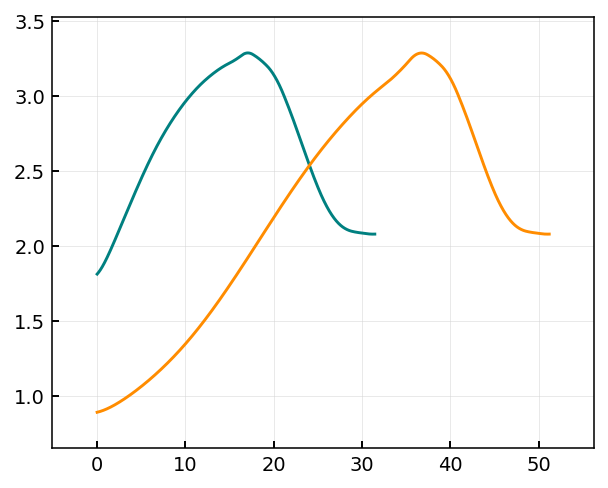

In [77]:
curve = "Curve 3"

dls1 = DLScase(store[curve][comparison[0]])
dls2 = DLScase(store[curve][comparison[1]])

fig, ax = plt.subplots()

for dls in [dls1, dls2]:
    ax.plot(dls.data["Spar"], dls.data["Btot"])

In [65]:
dls.data.keys()

Index(['Qrad', 'Spar', 'Spol', 'Te', 'qpar', 'Btot', 'Ne', 'cz', 'Xpoint',
       'qradial', 'Prad_per_area', 'Prad_per_area_cum',
       'Prad_per_area_cum_norm', 'Prad_cum', 'Prad_cum_norm', 'Pe',
       'qpar_over_B'],
      dtype='object')

In [50]:
df1 = dls1.get_stats_dataframe()
df2 = dls2.get_stats_dataframe()
df_ratio = (df2 / df1)

terms = 1/df_ratio[["Beff", "W_Tu", "curveclip", "upstream_rad"]]
display(terms)

terms.product(axis=1)


,Beff,W_Tu,curveclip,upstream_rad
0,1.800733,1.148423,1.014776,0.968609


0    2.032685
dtype: float64

In [51]:
print(terms)

       Beff      W_Tu  curveclip  upstream_rad
0  1.800733  1.148423   1.014776      0.968609


In [44]:

curve = "Curve 1"
sc = scaling_comparison(store[curve][comparison[0]], store[curve][comparison[1]], "density")

c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:651: SyntaxWarning: invalid escape sequence '\ '
  axes[1,2].set_ylabel("$S_{front, final} \ /\  S_{pol, x}$")
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:726: SyntaxWarning: invalid escape sequence '\/'
  if idx == 0: BxBtkwargs["label"] = "$B_{X} \/ B_{t}$"
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:1422: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel("$s_{\parallel}$ [m]")
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:1434: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$q_{\parallel}$ $[Wm^{-2}]$")
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:1448: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$q_{\parallel}/B_{tot}$ $[Wm^{-2}T^{-1}]$")
c:\Users\Mike\OneDrive\Project\python-packages\sdtools\DLS\postprocess.py:1732: SyntaxWarning: invalid escape sequenc

KeyError: 'density'